In [1]:
import numpy as np
import cv2
import os
from pdf2image import convert_from_path

def count_problems(page_rl):
    # 이미지를 흑백으로 변환
    imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)
    
    # 전체 영역에서 작업 (왼쪽 여백으로 제한하지 않음)
    # 이진화 - 배경은 흰색, 텍스트는 검은색으로
    _, thresh = cv2.threshold(imgray, 180, 255, cv2.THRESH_BINARY_INV)
    
    # 노이즈 제거
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # 연결 요소 레이블링
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned)
    
    # 문제 번호 위치 저장
    problem_positions = []
    
    # 각 연결 요소 분석
    for i in range(1, num_labels):  # 0은 배경이므로 제외
        x, y, w, h, area = stats[i]
        
        # 문제 번호의 예상 특성
        if (20 < w < 50 and 20 < h < 50  # 크기 제한
            and x < 150  # 왼쪽에 위치
            and area > 100 and area < 1000):  # 면적 제한
            
            # 디버깅을 위한 사각형 그리기
            cv2.rectangle(page_rl, (x, y), (x+w, y+h), (0, 0, 255), 2)
            problem_positions.append((y, x))
    
    # 디버깅용 이미지 저장
    cv2.imwrite(f'debug_numbers_{len(problem_positions)}.png', page_rl)
    
    # y 좌표로 정렬
    problem_positions.sort()
    
    return len(problem_positions)
# PDF 파일을 이미지로 변환 후, 문제 수 파악
def analyze_pdf(pdf_path):
    # PDF 파일을 이미지로 변환
    pages = convert_from_path(pdf_path, dpi=300)
    
    for page_num, page in enumerate(pages):
        # PIL Image를 OpenCV 형식으로 변환
        page_cv = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        
        # 페이지 분할
        right, left = imtrim(page_cv)
        
        # 각 반페이지의 문제 수 계산
        right_problems = count_problems(right)
        left_problems = count_problems(left)
        
        print(f"페이지 {page_num + 1}:")
        print(f"  왼쪽: {left_problems} 문제")
        print(f"  오른쪽: {right_problems} 문제")

# 실행
if __name__ == "__main__":
    pdf_path = "C:/q크롭/원본/2024_pil_A.pdf"
    analyze_pdf(pdf_path)

PDFInfoNotInstalledError: Unable to get page count. Is poppler installed and in PATH?

In [3]:
# def imtrim(page):
#     height, width = page.shape[:2]
    
#     # 페이지 중앙을 기준으로 분할
#     mid_point = width // 2
    
#     # 왼쪽 페이지
#     left = page[:, :mid_point]
    
#     # 오른쪽 페이지
#     right = page[:, mid_point:]
    
#     # 디버깅을 위해 분할된 이미지 저장
#     cv2.imwrite('debug_left.png', left)
#     cv2.imwrite('debug_right.png', right)
    
#     return right, left

# def count_problems(page_rl):
#     # 이미지를 흑백으로 변환
#     imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)
    
#     # 이진화 - 더 강한 대비를 위해 임계값 조정
#     _, thresh = cv2.threshold(imgray, 210, 255, cv2.THRESH_BINARY_INV)
    
#     # 노이즈 제거를 위한 모폴로지 연산
#     kernel = np.ones((2,2), np.uint8)
#     cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
#     # 디버깅용 이미지
#     debug_img = cv2.cvtColor(cleaned.copy(), cv2.COLOR_GRAY2BGR)
    
#     # 연결 요소 분석
#     contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     problem_positions = []
#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
        
#         # 문제 번호의 특성 확인
#         # 1. 왼쪽에 위치 (x < 100)
#         # 2. 적절한 크기 (너비와 높이가 비슷한 정사각형에 가까움)
#         # 3. 적절한 종횡비
#         aspect_ratio = float(w)/h
        
#         if (x < 100 and  # 왼쪽 여백 내
#             15 < w < 35 and 15 < h < 35 and  # 크기 제한
#             0.8 < aspect_ratio < 1.2):  # 정사각형에 가까움
            
#             # 디버깅을 위한 시각화
#             cv2.rectangle(debug_img, (x,y), (x+w,y+h), (0,0,255), 2)
#             cv2.putText(debug_img, f'{w}x{h}', (x,y-5), 
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
            
#             problem_positions.append(y)
    
#     # y 좌표로 정렬
#     problem_positions.sort()
    
#     # 디버깅 이미지 저장 - 페이지 구분을 위해 타임스탬프 추가
#     timestamp = int(time.time())
#     cv2.imwrite(f'debug_detection_{timestamp}.png', debug_img)
    
#     return len(problem_positions)

In [4]:

# # PDF 파일을 이미지로 변환 후, 문제 크롭 실행
# def problem_crop_from_pdf(pdf_path, save_path):
#     # PDF 파일을 이미지로 변환
#     pages = convert_from_path(pdf_path, dpi=300)

#     # 저장할 폴더가 없으면 생성
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
    
#     # PDF 페이지를 저장할 서브 폴더 'pages' 생성
#     pages_folder = os.path.join(save_path, 'pages')
#     if not os.path.exists(pages_folder):
#         os.makedirs(pages_folder)

#     # 문제 이미지를 저장할 서브 폴더 'problems' 생성
#     problems_folder = os.path.join(save_path, 'problems')
#     if not os.path.exists(problems_folder):
#         os.makedirs(problems_folder)

#     # 각 페이지에 대해 처리
#     for page_num, page in enumerate(pages):
#         # 페이지 이미지를 PIL Image 객체로 변환
#         page_image = page
        
#         # 이미지 크기 가져오기
#         width, height = page_image.size
        
#         # 왼쪽 절반과 오른쪽 절반으로 나누기
#         left_half = page_image.crop((0, 0, width//2, height))
#         right_half = page_image.crop((width//2, 0, width, height))
        
#         # 각 절반 이미지 저장
#         left_half_path = os.path.join(problems_folder, f"page_{page_num + 1}_left.png")
#         right_half_path = os.path.join(problems_folder, f"page_{page_num + 1}_right.png")
        
#         left_half.save(left_half_path, 'PNG')
#         right_half.save(right_half_path, 'PNG')
        
#         # 원본 페이지도 저장
#         page_image_path = os.path.join(pages_folder, f"page_{page_num + 1}.png")
#         page_image.save(page_image_path, 'PNG')
        
#         print(f"페이지 {page_num + 1} 처리 완료:")
#         print(f"- 원본 저장: {page_image_path}")
#         print(f"- 왼쪽 절반 저장: {left_half_path}")
#         print(f"- 오른쪽 절반 저장: {right_half_path}")

# problem_crop_from_pdf("C:/Users/user/Downloads/2024_pil_A.pdf","C:/Users/user/Downloads/")



# problem_crop_from_pdf("C:/Users/user/Downloads/2024_pil_A.pdf","C:/Users/user/Downloads/")

In [5]:
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt

# def analyze_dark_pixels(image_path, y_target, threshold=100):
#     """
#     Analyze dark pixels along the x-axis for a given y-coordinate in an image.

#     Parameters:
#         image_path (str): Path to the input image file.
#         y_target (int): The y-coordinate to analyze.
#         threshold (int): The intensity threshold to detect dark pixels.

#     Returns:
#         list: X-coordinates where dark pixels are detected.
#     """
#     # Load and convert the image to grayscale
#     image = Image.open(image_path)
#     gray_image = image.convert("L")
#     gray_array = np.array(gray_image)

#     # Extract the pixel intensities along the x-axis for the given y-coordinate
#     vertical_line = gray_array[y_target, :]

#     # Detect positions of dark pixels (intensity < threshold)
#     dark_pixel_positions = np.where(vertical_line < threshold)[0]

#     # Visualize the results
#     plt.figure(figsize=(10, 4))
#     plt.plot(range(len(vertical_line)), vertical_line, label="Pixel Intensity")
#     plt.scatter(dark_pixel_positions, vertical_line[dark_pixel_positions], color='red', label="Dark Pixels (<Threshold)")
#     plt.title(f"Pixel Intensity Along X-axis at Y={y_target}")
#     plt.xlabel("X-coordinate")
#     plt.ylabel("Pixel Intensity")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Return the detected dark pixel positions
#     return dark_pixel_positions.tolist()


# # Example usage
# image_path = "/mnt/data/page_14_left.png"  # Path to the image
# y_target = 71  # Target y-coordinate to analyze
# threshold = 100  # Intensity threshold for detecting dark pixels

# # Perform the analysis
# dark_pixels = analyze_dark_pixels(image_path, y_target, threshold)

# print(f"Dark pixels detected at x-coordinates: {dark_pixels}")


In [6]:
image_path = 'C:/Users/user/Downloads/qcrop/original/2024_pil_A.pdf'
# detect_black_pixels(image_path)


In [1]:
import os
import fitz  # PyMuPDF
from PIL import Image

# PDF 경로 설정
pdf_path = "C:/Users/user/Downloads/qcrop/original/"
output_path = os.path.join(pdf_path, "converted_images")

# 출력 폴더 생성
os.makedirs(output_path, exist_ok=True)

# PDF 파일 목록 가져오기
pdf_files = [f for f in os.listdir(pdf_path) if f.endswith('.pdf')]

# PDF의 각 페이지를 세로 방향으로 절반 나누어 저장하는 함수
def convert_and_split_pdf_to_png(pdf_file, output_dir):
    pdf_document = fitz.open(pdf_file)
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap()

        # PIL 이미지를 사용해 세로로 나눔
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        mid_x = pix.width // 2

        left_img = img.crop((0, 0, mid_x, pix.height))
        right_img = img.crop((mid_x, 0, pix.width, pix.height))

        base_filename = f"{os.path.splitext(os.path.basename(pdf_file))[0]}_page_{page_num + 1}"
        left_img.save(os.path.join(output_dir, f"{base_filename}_left.png"))
        right_img.save(os.path.join(output_dir, f"{base_filename}_right.png"))
    pdf_document.close()

# 변환 및 저장 실행
for pdf_file in pdf_files:
    pdf_full_path = os.path.join(pdf_path, pdf_file)
    convert_and_split_pdf_to_png(pdf_full_path, output_path)

print(f"PDF 파일을 PNG로 변환 및 세로로 나누는 작업 완료! 변환된 파일은 {output_path}에 저장되었습니다.")


RuntimeError: Directory 'static/' does not exist

In [7]:
import cv2
import os

def crop_image_half(image_path, output_folder_left, output_folder_right):
    """
    이미지를 세로로 절반으로 잘라서 왼쪽과 오른쪽 이미지를 각각 저장하는 함수.
    
    :param image_path: 원본 이미지 경로
    :param output_folder_left: 왼쪽 이미지를 저장할 폴더 경로
    :param output_folder_right: 오른쪽 이미지를 저장할 폴더 경로
    """
    # 이미지 로드
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"이미지 로드 실패: {image_path}")
        return
    
    # 이미지의 높이와 너비
    height, width, _ = image.shape
    
    # 이미지의 세로 절반으로 나누기
    left_half = image[:, :width//2]  # 왼쪽 절반
    right_half = image[:, width//2:]  # 오른쪽 절반
    
    # 왼쪽 폴더가 없으면 생성
    if not os.path.exists(output_folder_left):
        os.makedirs(output_folder_left)
        
    # 오른쪽 폴더가 없으면 생성
    if not os.path.exists(output_folder_right):
        os.makedirs(output_folder_right)
    
    # 파일 이름을 원본 파일에서 추출
    file_name = os.path.basename(image_path)
    
    # 왼쪽 절반 저장
    left_image_path = os.path.join(output_folder_left, file_name)
    cv2.imwrite(left_image_path, left_half)
    
    # 오른쪽 절반 저장
    right_image_path = os.path.join(output_folder_right, file_name)
    cv2.imwrite(right_image_path, right_half)
    
    print(f"왼쪽 이미지 저장: {left_image_path}")
    print(f"오른쪽 이미지 저장: {right_image_path}")

# 예시 사용법
image_path = 'C:/Users/softgear/Desktop/cropped_problems/pages/page_13.png'  # 처리할 이미지 파일 경로
output_folder_left = 'C:/Users/softgear/Desktop/cropped_problems/left_images'  # 왼쪽 이미지를 저장할 폴더
output_folder_right = 'C:/Users/softgear/Desktop/cropped_problems/right_images'  # 오른쪽 이미지를 저장할 폴더

crop_image_half(image_path, output_folder_left, output_folder_right)


ModuleNotFoundError: No module named 'cv2'

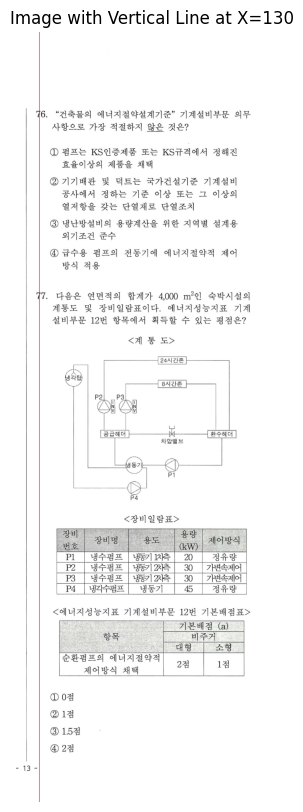

In [23]:
import cv2
import matplotlib.pyplot as plt

def overlay_x_line(image_path, x_target, output_path="output_with_x_line.png"):
    """
    Overlay a vertical line at a specific x-coordinate on the image.

    Parameters:
        image_path (str): Path to the input image file.
        x_target (int): The x-coordinate where the line will be overlaid.
        output_path (str): Path to save the output image with the overlay.

    Returns:
        None
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return

    # Add a vertical line at x_target (BGR color: red)
    line_color = (0, 0, 255)  # Red color in BGR
    line_thickness = 2
    image_with_line = cv2.line(image, (x_target, 0), (x_target, image.shape[0]), line_color, line_thickness)

    # Save the output image with the overlay
    cv2.imwrite(output_path, image_with_line)

    # Display the image with the overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_line, cv2.COLOR_BGR2RGB))
    plt.title(f"Image with Vertical Line at X={x_target}")
    plt.axis("off")
    plt.show()

# Example usage
x_target = 130  # Example x-coordinate to overlay the line
overlay_x_line('C:/Users/softgear/Desktop/cropped_problems/right_images/page_13.png', x_target)


In [20]:
# import cv2
# import numpy as np

# def analyze_vertical_line(image_path, x_target, threshold=100):
#     """
#     Analyze pixels along the y-axis for a given x-coordinate in an image.

#     Parameters:
#         image_path (str): Path to the input image file.
#         x_target (int): The x-coordinate to analyze.
#         threshold (int): The intensity threshold to detect dark pixels.

#     Returns:
#         list: Y-coordinates where dark pixels are detected.
#     """
#     # Load the image using OpenCV
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale for intensity analysis
#     if image is None:
#         print("Failed to load image.")
#         return

#     # Extract the pixel intensities along the y-axis at x_target
#     vertical_line = image[:, x_target]

#     # Detect positions of dark pixels (intensity < threshold)
#     dark_pixel_positions = np.where(vertical_line < threshold)[0]

#     # Visualize the pixel intensity along the y-axis
#     plt.figure(figsize=(6, 10))
#     plt.plot(vertical_line, range(len(vertical_line)), label="Pixel Intensity")
#     plt.scatter(vertical_line[dark_pixel_positions], dark_pixel_positions, color='red', label="Dark Pixels (<Threshold)")
#     plt.gca().invert_yaxis()  # Match image coordinate system
#     plt.title(f"Pixel Intensity Along Y-axis at X={x_target}")
#     plt.xlabel("Pixel Intensity")
#     plt.ylabel("Y-coordinate")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Return the detected y-coordinates of dark pixels
#     return dark_pixel_positions.tolist()


# # Example usage
# x_target = 330  # x-coordinate to analyze
# threshold = 100  # Intensity threshold for detecting dark pixels
# dark_pixels = analyze_vertical_line(image_path, x_target, threshold)

# print(f"Dark pixels detected at y-coordinates: {dark_pixels}")


In [21]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# def analyze_vertical_line_with_skip(image_path, x_target, threshold=100, skip=60):
#     """
#     Analyze pixels along the y-axis for a given x-coordinate in an image,
#     skipping a defined number of pixels after each detection.

#     Parameters:
#         image_path (str): Path to the input image file.
#         x_target (int): The x-coordinate to analyze.
#         threshold (int): The intensity threshold to detect dark pixels.
#         skip (int): Number of pixels to skip after detecting a dark pixel.

#     Returns:
#         list: Y-coordinates where dark pixels are detected.
#     """
#     # Load the image using OpenCV
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale for intensity analysis
#     if image is None:
#         print("Failed to load image.")
#         return

#     # Extract the pixel intensities along the y-axis at x_target
#     vertical_line = image[:, x_target]

#     # Initialize variables
#     dark_pixel_positions = []  # List to store detected dark pixel positions
#     y = 0  # Start from the top of the image

#     while y < len(vertical_line):
#         if vertical_line[y] < threshold:
#             # Dark pixel detected, add its position
#             dark_pixel_positions.append(y)
#             # Skip the next `skip` pixels
#             y += skip
#         else:
#             # Move to the next pixel
#             y += 1

#     # Visualize the pixel intensity along the y-axis
#     plt.figure(figsize=(6, 10))
#     plt.plot(vertical_line, range(len(vertical_line)), label="Pixel Intensity")
#     plt.scatter(vertical_line[dark_pixel_positions], dark_pixel_positions, color='red', label="Detected Pixels")
#     plt.gca().invert_yaxis()  # Match image coordinate system
#     plt.title(f"Pixel Intensity Along Y-axis at X={x_target} (With Skipping)")
#     plt.xlabel("Pixel Intensity")
#     plt.ylabel("Y-coordinate")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Return the detected y-coordinates of dark pixels
#     return dark_pixel_positions


# # Example usage
# x_target = 330  # x-coordinate to analyze
# threshold = 100  # Intensity threshold for detecting dark pixels
# skip = 60  # Number of pixels to skip after detection
# dark_pixels = analyze_vertical_line_with_skip(image_path, x_target, threshold, skip)

# print(f"Dark pixels detected at y-coordinates: {dark_pixels}")


Detected (x, y) coordinates: [(130, 441), (130, 1455)]


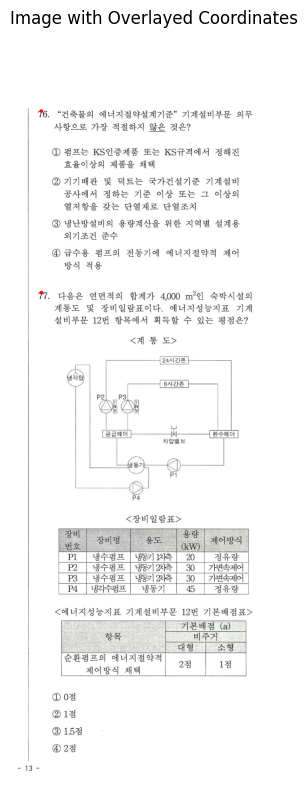

In [25]:
import cv2
import matplotlib.pyplot as plt


#이미지에서 특정 x-좌표를 기준으로 y-축을 따라 픽셀의 밝기를 분석하고, 어두운 픽셀을 찾은 후 이를 (x, y) 좌표로 저장
def analyze_and_store_coordinates(image_path, x_target, threshold=100, skip=60):
    """
    Analyze pixels along the y-axis for a given x-coordinate in an image,
    storing detected coordinates after skipping a defined number of pixels.

    Parameters:
        image_path (str): Path to the input image file.
        x_target (int): The x-coordinate to analyze.
        threshold (int): The intensity threshold to detect dark pixels.
        skip (int): Number of pixels to skip after detecting a dark pixel.

    Returns:
        list: Detected (x, y) coordinates of dark pixels.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale for intensity analysis
    if image is None:
        print("Failed to load image.")
        return []

    # Extract the pixel intensities along the y-axis at x_target
    vertical_line = image[:, x_target]

    # Initialize variables
    coordinates = []  # List to store detected (x, y) positions
    y = 0  # Start from the top of the image

    while y < len(vertical_line):
        if vertical_line[y] < threshold:
            # Dark pixel detected, add its (x, y) position
            coordinates.append((x_target, y))
            # Skip the next `skip` pixels
            y += skip
        else:
            # Move to the next pixel
            y += 1

    return coordinates


#analyze_and_store_coordinates 함수로부터 받은 좌표들을 이미지 위에 표시
def overlay_coordinates(image_path, coordinates, output_path="output_with_coordinates.png"):
    """
    Overlay specified coordinates on the image.

    Parameters:
        image_path (str): Path to the input image file.
        coordinates (list of tuples): List of (x, y) coordinates to overlay.
        output_path (str): Path to save the output image with the overlay.

    Returns:
        None
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return

    # Overlay each coordinate as a circle on the image
    for (x, y) in coordinates:
        # Draw a circle at each (x, y) coordinate (BGR color: red)
        circle_color = (0, 0, 255)  # Red color in BGR
        circle_radius = 10
        circle_thickness = -1  # Filled circle
        cv2.circle(image, (x, y), circle_radius, circle_color, circle_thickness)

    # Save the output image with the overlay
    cv2.imwrite(output_path, image)

    # Display the image with the overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image with Overlayed Coordinates")
    plt.axis("off")
    plt.show()



image_path = "C:/Users/softgear/Desktop/cropped_problems/right_images/page_13.png"
# Example usage
x_target = 130  # x-coordinate to analyze
threshold = 100  # Intensity threshold for detecting dark pixels
skip = 60  # Number of pixels to skip after detection

# Analyze the image and store the detected coordinates
coordinates = analyze_and_store_coordinates(image_path, x_target, threshold, skip)

# Print detected coordinates
print("Detected (x, y) coordinates:", coordinates)

# Overlay the detected coordinates on the image
overlay_coordinates(image_path, coordinates)


Skipping invalid crop region: (80, 391, 80, 1405)
Cropped image saved: cropped_images\cropped_2.png


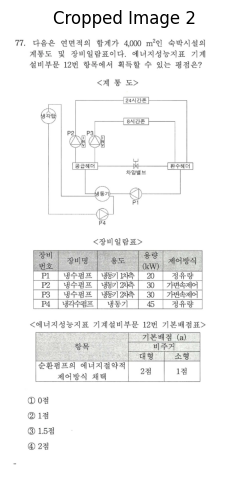

In [26]:
# import cv2
# import os
# import matplotlib.pyplot as plt

# def crop_image_by_coordinates(image_path, coordinates, output_folder="cropped_images"):
#     """
#     Crop the image based on a list of coordinates and save the cropped parts,
#     with x and y values reduced by 50 pixels for each cropping.

#     Parameters:
#         image_path (str): Path to the input image file.
#         coordinates (list of tuples): List of (x, y) coordinates for cropping.
#         output_folder (str): Folder to save the cropped images.

#     Returns:
#         None
#     """
#     # Load the image using OpenCV
#     image = cv2.imread(image_path)
#     if image is None:
#         print("Failed to load image.")
#         return

#     # Ensure the output folder exists
#     os.makedirs(output_folder, exist_ok=True)

#     # Get image dimensions
#     height, width, _ = image.shape

#     # Process each coordinate and crop the image
#     for i, (x, y) in enumerate(coordinates):
#         # Adjust cropping box by reducing 50 pixels from x and y
#         x_start = max(0, x - 50)  # Ensure it's not less than 0
#         y_start = max(0, y - 50)  # Ensure it's not less than 0
#         x_end = width if i == len(coordinates) - 1 else min(width, coordinates[i + 1][0] - 50)
#         y_end = height if i == len(coordinates) - 1 else min(height, coordinates[i + 1][1] - 50)

#         # Ensure cropping coordinates are valid
#         if y_start >= y_end or x_start >= x_end:
#             print(f"Skipping invalid crop region: ({x_start}, {y_start}, {x_end}, {y_end})")
#             continue

#         # Crop the image
#         cropped_image = image[y_start:y_end, x_start:x_end]

#         # Save the cropped image
#         output_path = os.path.join(output_folder, f"cropped_{i + 1}.png")
#         cv2.imwrite(output_path, cropped_image)

#         print(f"Cropped image saved: {output_path}")

#         # Display cropped region
#         plt.figure(figsize=(6, 6))
#         plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
#         plt.title(f"Cropped Image {i + 1}")
#         plt.axis("off")
#         plt.show()

# crop_image_by_coordinates(image_path, coordinates)


Skipping invalid crop region: (280, 396, 280, 1469)
Skipping invalid crop region: (280, 1469, 280, 2529)
Cropped image saved: cropped_images\cropped_3.png


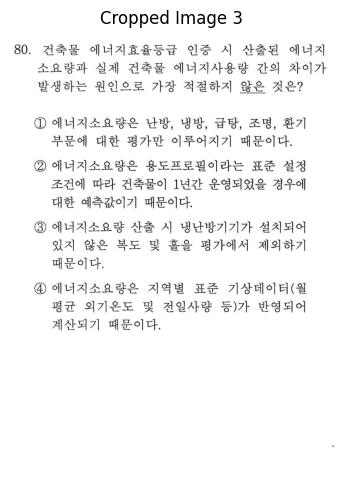

In [ ]:
# import cv2
# import os
# import matplotlib.pyplot as plt

# def crop_image_by_coordinates(image_path, coordinates, output_folder="cropped_images"):
#     """
#     Crop the image based on a list of coordinates and save the cropped parts,
#     with x and y values reduced by 50 pixels for each cropping.

#     Parameters:
#         image_path (str): Path to the input image file.
#         coordinates (list of tuples): List of (x, y) coordinates for cropping.
#         output_folder (str): Folder to save the cropped images.

#     Returns:
#         None
#     """
#     # Load the image using OpenCV
#     image = cv2.imread(image_path)
#     if image is None:
#         print("Failed to load image.")
#         return

#     # Ensure the output folder exists
#     os.makedirs(output_folder, exist_ok=True)

#     # Get image dimensions
#     height, width, _ = image.shape

#     # Process each coordinate and crop the image
#     for i, (x, y) in enumerate(coordinates):
#         # Adjust cropping box by reducing 50 pixels from x and y
#         x_start = max(0, x - 50)  # Ensure it's not less than 0
#         y_start = max(0, y - 50)  # Ensure it's not less than 0
#         x_end = width if i == len(coordinates) - 1 else min(width, coordinates[i + 1][0] - 50)
#         y_end = height if i == len(coordinates) - 1 else min(height, coordinates[i + 1][1] - 50)

#         # Ensure cropping coordinates are valid
#         if y_start >= y_end or x_start >= x_end:
#             print(f"Skipping invalid crop region: ({x_start}, {y_start}, {x_end}, {y_end})")
#             continue

#         # Crop the image
#         cropped_image = image[y_start:y_end, x_start:x_end]

#         # Save the cropped image
#         output_path = os.path.join(output_folder, f"cropped_{i + 1}.png")
#         cv2.imwrite(output_path, cropped_image)

#         print(f"Cropped image saved: {output_path}")

#         # Display cropped region
#         plt.figure(figsize=(6, 6))
#         plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
#         plt.title(f"Cropped Image {i + 1}")
#         plt.axis("off")
#         plt.show()

# crop_image_by_coordinates(image_path, coordinates)


Cropped image saved: cropped_images\cropped_1.png


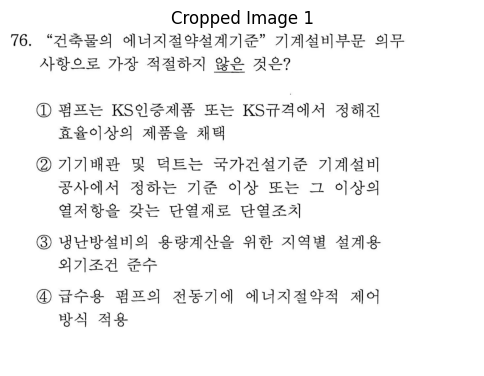

Cropped image saved: cropped_images\cropped_2.png


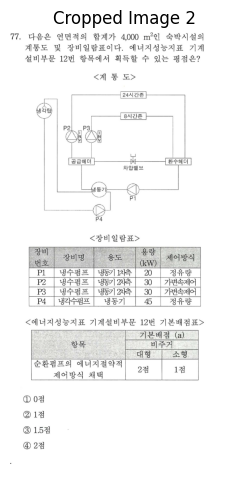

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def crop_image_by_coordinates(image_path, coordinates, output_folder="cropped_images"):
    """
    Crop the image based on a list of coordinates and save the cropped parts,
    while also displaying the cropped images.

    Parameters:
        image_path (str): Path to the input image file.
        coordinates (list of tuples): List of (x, y) coordinates for cropping.
        output_folder (str): Folder to save the cropped images.

    Returns:
        None
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Get image dimensions
    height, width, _ = image.shape

    # Process each coordinate and crop the image
    for i, (x, y) in enumerate(coordinates):
        # Determine the cropping box
        x_start = x  # Crop from the x-coordinate
        y_start = y  # Crop from the y-coordinate
        x_end = width  # Always crop to the full width
        y_end = height if i == len(coordinates) - 1 else coordinates[i + 1][1]  # Next y or full height

        # Ensure cropping coordinates are within image boundaries
        x_start = max(0, min(x_start, width))
        x_end = max(0, min(x_end, width))
        y_start = max(0, min(y_start, height))
        y_end = max(0, min(y_end, height))

        # Check if the cropping box is valid
        if y_start >= y_end or x_start >= x_end:
            print(f"Skipping invalid crop region: ({x_start}, {y_start}, {x_end}, {y_end})")
            continue

        # Crop the image
        cropped_image = image[y_start:y_end, x_start:x_end]

        # Save the cropped image
        output_path = os.path.join(output_folder, f"cropped_{i + 1}.png")
        cv2.imwrite(output_path, cropped_image)

        print(f"Cropped image saved: {output_path}")

        # Display the cropped image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Cropped Image {i + 1}")
        plt.axis("off")
        plt.show()


def modify_coordinates(coordinates):
    return [(x - 20, y - 10) for x, y in coordinates]

new_coordinates = modify_coordinates(coordinates)
crop_image_by_coordinates(image_path, new_coordinates)


In [24]:
# import cv2
# import matplotlib.pyplot as plt

# def overlay_coordinates(image_path, coordinates, output_path="output_with_coordinates.png"):
#     """
#     Overlay specified coordinates on the image.

#     Parameters:
#         image_path (str): Path to the input image file.
#         coordinates (list of tuples): List of (x, y) coordinates to overlay.
#         output_path (str): Path to save the output image with the overlay.

#     Returns:
#         None
#     """
#     # Load the image using OpenCV
#     image = cv2.imread(image_path)
#     if image is None:
#         print("Failed to load image.")
#         return

#     # Overlay each coordinate as a circle on the image
#     for (x, y) in coordinates:
#         # Draw a circle at each (x, y) coordinate (BGR color: red)
#         circle_color = (0, 0, 255)  # Red color in BGR
#         circle_radius = 10
#         circle_thickness = -1  # Filled circle
#         cv2.circle(image, (x, y), circle_radius, circle_color, circle_thickness)

#     # Save the output image with the overlay
#     cv2.imwrite(output_path, image)

#     # Display the image with the overlay
#     plt.figure(figsize=(10, 10))
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.title("Image with Overlayed Coordinates")
#     plt.axis("off")
#     plt.show()

# # Example usage
# coordinates = [(330, 446), (330, 1519), (330, 2579)]  # List of coordinates to overlay
# overlay_coordinates(image_path, coordinates)
